In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')


modules loaded


In [2]:
# قائمة المسارات للمجلدات TRAIN و TEST
data_dirs = [
    r'C:/Users/LAP-STORE/Desktop/Amit/computer vesion/blood/dataset2-master/dataset2-master/images/TRAIN',
    r'C:/Users/LAP-STORE/Desktop/Amit/computer vesion/blood/dataset2-master/dataset2-master/images/TEST'
]

filepaths = []
labels = []

# مرّ على كل مجلد رئيسي (TRAIN و TEST)
for data_dir in data_dirs:
    folds = os.listdir(data_dir)  # المجلدات الفرعية (التي تمثل الفئات)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        if fold in ['ig', 'neutrophil']:
            continue
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

# دمج المسارات والتسميات في DataFrame
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)


In [3]:
df

filepaths      labels
0      C:/Users/LAP-STORE/Desktop/Amit/computer vesio...  EOSINOPHIL
1      C:/Users/LAP-STORE/Desktop/Amit/computer vesio...  EOSINOPHIL
2      C:/Users/LAP-STORE/Desktop/Amit/computer vesio...  EOSINOPHIL
3      C:/Users/LAP-STORE/Desktop/Amit/computer vesio...  EOSINOPHIL
4      C:/Users/LAP-STORE/Desktop/Amit/computer vesio...  EOSINOPHIL
...                                                  ...         ...
12439  C:/Users/LAP-STORE/Desktop/Amit/computer vesio...  NEUTROPHIL
12440  C:/Users/LAP-STORE/Desktop/Amit/computer vesio...  NEUTROPHIL
12441  C:/Users/LAP-STORE/Desktop/Amit/computer vesio...  NEUTROPHIL
12442  C:/Users/LAP-STORE/Desktop/Amit/computer vesio...  NEUTROPHIL
12443  C:/Users/LAP-STORE/Desktop/Amit/computer vesio...  NEUTROPHIL

[12444 rows x 2 columns]

In [4]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)



In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# crobed image size
batch_size = 128
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)




Found 9955 validated image filenames belonging to 4 classes.
Found 1493 validated image filenames belonging to 4 classes.
Found 996 validated image filenames belonging to 4 classes.


In [6]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's keys (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize=(20, 20))

for i in range(min(batch_size, 16)):  # Ensure the loop does not exceed the grid size (4x4)
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# تعريف Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# تطبيق فقط rescale على بيانات الاختبار، بدون Augmentation
test_datagen = ImageDataGenerator(rescale=1./255)


# تطبيق Data Augmentation على بيانات التدريب
train_gen = train_datagen.flow_from_dataframe(
    train_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size, 
    class_mode='categorical', 
    color_mode='rgb', 
    batch_size=batch_size
)


test_gen = test_datagen.flow_from_dataframe(
    test_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size, 
    class_mode='categorical', 
    color_mode='rgb', 
    batch_size=batch_size, 
    shuffle=False  # يجب أن تكون False في بيانات الاختبار
)


# تطبيق على بيانات التحقق
valid_gen = valid_datagen.flow_from_dataframe(
    valid_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size, 
    class_mode='categorical', 
    color_mode='rgb', 
    batch_size=batch_size
)



Found 9955 validated image filenames belonging to 4 classes.
Found 996 validated image filenames belonging to 4 classes.
Found 1493 validated image filenames belonging to 4 classes.


Found 9955 validated image filenames belonging to 4 classes.
Found 1493 validated image filenames belonging to 4 classes.
Found 996 validated image filenames belonging to 4 classes.


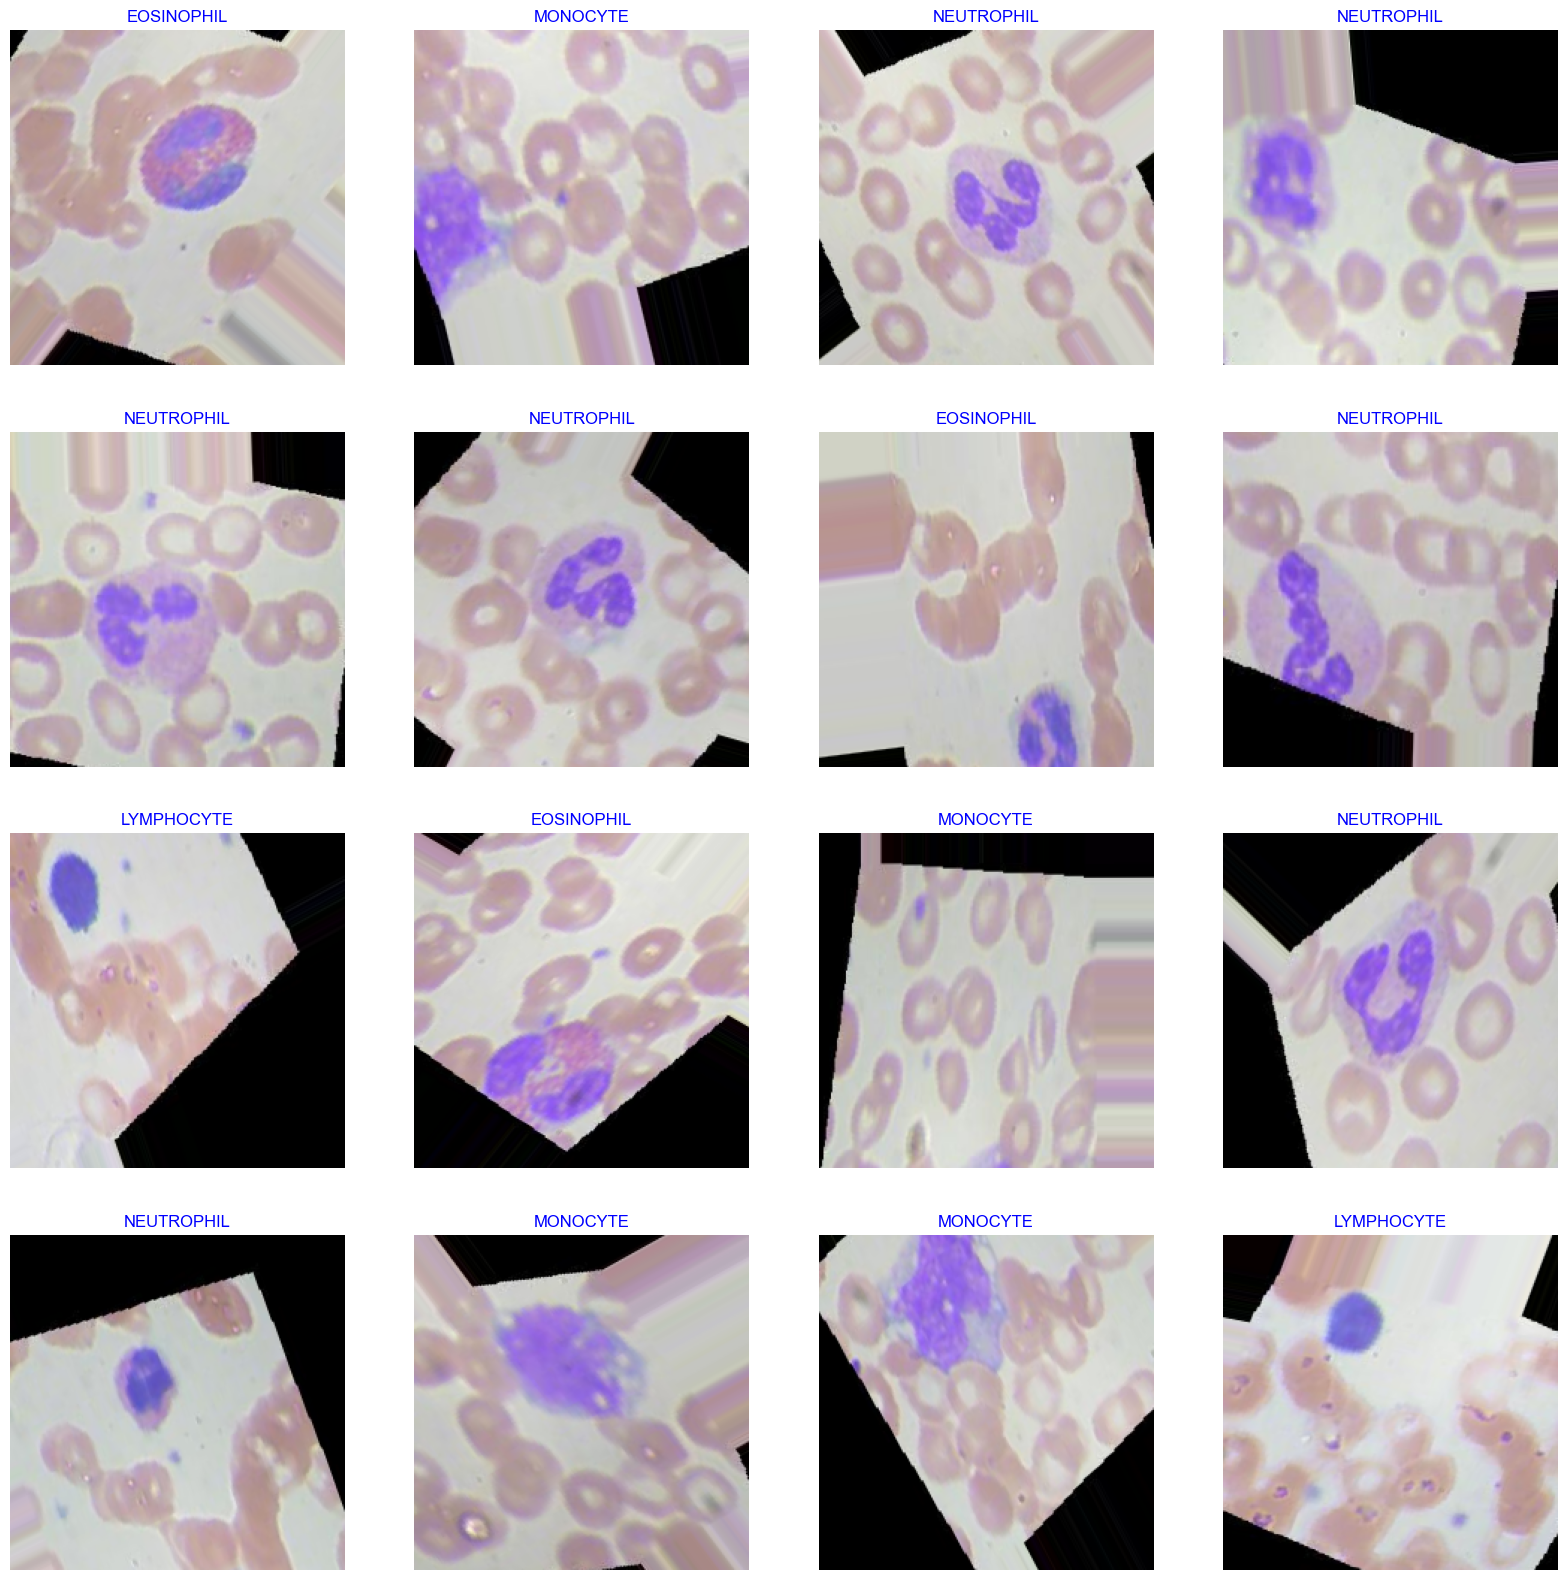

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# تعريف Data Augmentation لبيانات التدريب
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# تعريف Data Augmentation لبيانات التحقق (بدون augmentations فقط rescale)
valid_datagen = ImageDataGenerator(rescale=1./255)

# تعريف Data Augmentation لبيانات الاختبار (فقط rescale)
test_datagen = ImageDataGenerator(rescale=1./255)

# تطبيق Data Augmentation على بيانات التدريب
train_gen = train_datagen.flow_from_dataframe(
    train_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size, 
    class_mode='categorical', 
    color_mode='rgb', 
    batch_size=batch_size
)

# تطبيق على بيانات التحقق
valid_gen = valid_datagen.flow_from_dataframe(
    valid_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size, 
    class_mode='categorical', 
    color_mode='rgb', 
    batch_size=batch_size
)

# تطبيق فقط rescale على بيانات الاختبار
test_gen = test_datagen.flow_from_dataframe(
    test_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size, 
    class_mode='categorical', 
    color_mode='rgb', 
    batch_size=batch_size, 
    shuffle=False  # يجب أن تكون False في بيانات الاختبار
)

# التأكد من أن بيانات الاختبار لا يتم تحريفها
g_dict = train_gen.class_indices  # defines dictionary {'class': index}
classes = list(g_dict.keys())      # defines list of dictionary's keys (classes), classes names : string
images, labels = next(train_gen)   # get a batch size samples from the generator

# عرض مجموعة من الصور مع تسمياتها
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))

for i in range(min(batch_size, 16)):  # Ensure the loop does not exceed the grid size (4x4)
    plt.subplot(4, 4, i + 1)
    image = images[i]  # 이미지를 가져와서 그리기
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import InceptionV3  # استيراد InceptionV3

# إنشاء نموذج Inception
inception_model = Sequential()

# إضافة طبقات الـ Inception Model الأساسية
inception_model.add(InceptionV3(input_shape=img_shape, weights='imagenet', include_top=False))
inception_model.add(GlobalAveragePooling2D())  # إضافة طبقة Pooling بعد الـ Inception

# إضافة طبقات Dense إضافية
inception_model.add(Dense(512, activation='relu'))
inception_model.add(Dropout(0.4))  # تعديل نسبة الـ Dropout

# إضافة طبقة إخراج (Output Layer)
inception_model.add(Dense(len(classes), activation='softmax'))

# اختيار الـ Optimizer Adamax مع تعديل الـ learning rate
optimizer = Adamax(learning_rate=0.0005)

# تجميع النموذج مع تحديد الـ loss و metrics
inception_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# تجميد بعض الطبقات العليا من الـ Inception (تجميد آخر 10 طبقات)
for layer in inception_model.layers[:-10]:  # جمّد 10 طبقات فقط
    layer.trainable = False

# تحديد الـ EarlyStopping للمراقبة
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# عرض ملخص النموذج
inception_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,853,924 (87.18 MB)

 Trainable params: 22,819,492 (87.05 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [12]:
# تدريب النموذج
history = inception_model.fit(
    train_gen,
    epochs=10,
    validation_data=valid_gen,
    callbacks=[early_stopping]
)


Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1298s 16s/step - accuracy: 0.6008 - loss: 0.9087 - val_accuracy: 0.8761 - val_loss: 0.3443
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1110s 14s/step - accuracy: 0.9534 - loss: 0.1258 - val_accuracy: 0.9444 - val_loss: 0.1561
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1162s 15s/step - accuracy: 0.9803 - loss: 0.0550 - val_accuracy: 0.9826 - val_loss: 0.0528
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1597s 20s/step - accuracy: 0.9875 - loss: 0.0391 - val_accuracy: 0.9826 - val_loss: 0.0422
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1144s 15s/step - accuracy: 0.9887 - loss: 0.0329 - val_accuracy: 0.9953 - val_loss: 0.0175
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1151s 15s/step - accuracy: 0.9942 - loss: 0.0168 - val_accuracy: 0.9973 - val_loss: 0.0107
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 10222s 133s/step - accuracy: 0.9935 - loss: 0.0185 - val_accuracy: 0.9987 - val_loss: 0.0021
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1116s 14s/step - accuracy: 0.9953 - loss: 0.0138 - val_ac

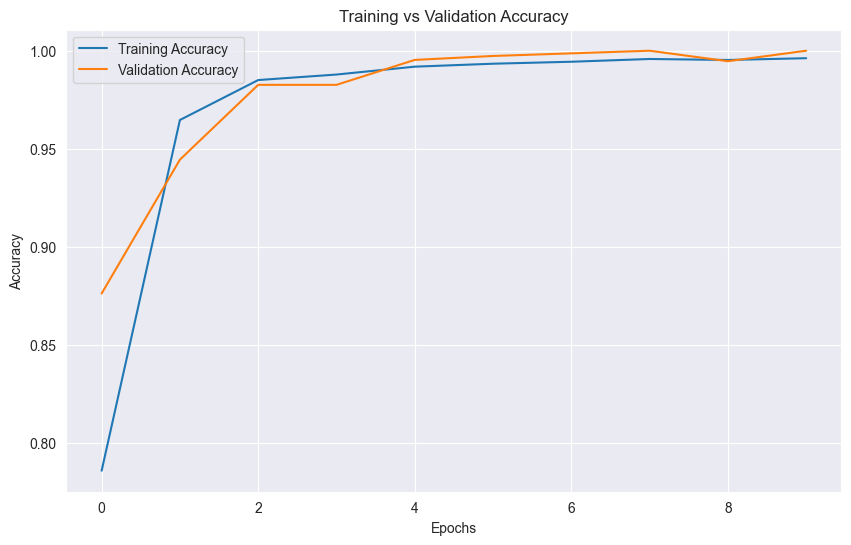

In [13]:
import matplotlib.pyplot as plt

# استخراج دقة التدريب و دقة التحقق من history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# رسم الدقة عبر الـ epochs
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# تقييم النموذج على بيانات الاختبار
test_loss, test_accuracy = inception_model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 1.0000 - loss: 2.3201e-04
Test Accuracy: 100.00%
Test Loss: 0.0002


In [18]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = inception_model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = inception_model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = inception_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

83/83 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - accuracy: 0.9990 - loss: 0.0056
83/83 ━━━━━━━━━━━━━━━━━━━━ 38s 419ms/step - accuracy: 1.0000 - loss: 1.9596e-04
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 280ms/step - accuracy: 1.0000 - loss: 2.3176e-04
Train Loss:  0.0076050302013754845
Train Accuracy:  0.9982923269271851
--------------------
Validation Loss:  0.00019586656708270311
Validation Accuracy:  1.0
--------------------
Test Loss:  0.00023173484078142792
Test Accuracy:  1.0


8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step
              precision    recall  f1-score   support

  EOSINOPHIL       1.00      1.00      1.00       261
  LYMPHOCYTE       1.00      1.00      1.00       240
    MONOCYTE       1.00      1.00      1.00       240
  NEUTROPHIL       1.00      1.00      1.00       255

    accuracy                           1.00       996
   macro avg       1.00      1.00      1.00       996
weighted avg       1.00      1.00      1.00       996



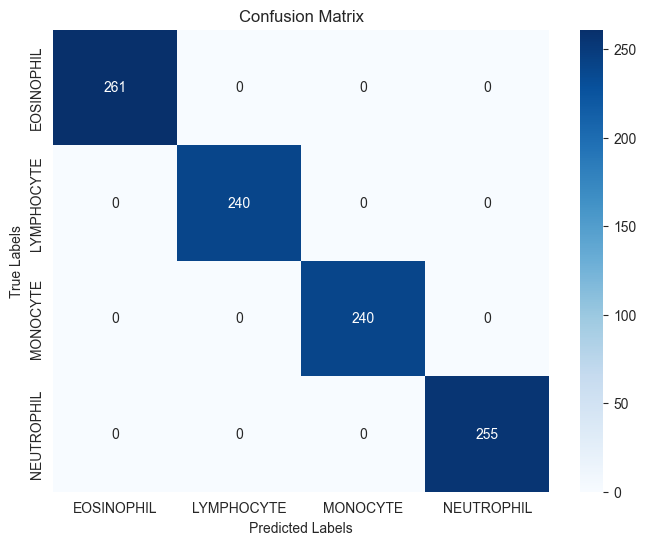

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# الحصول على التنبؤات من الموديل
y_pred_probs = inception_model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# الحصول على التسميات الحقيقية
y_true = test_gen.classes

# أسماء الفئات
class_names = list(test_gen.class_indices.keys())

# طباعة classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# إنشاء مصفوفة الالتباس
cm = confusion_matrix(y_true, y_pred)

# رسم مصفوفة الالتباس
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [19]:
#Save the model
inception_model.save('inception_model.h5')

In [20]:
import tensorflow as tf

# تحميل نموذج .h5
model = tf.keras.models.load_model("C:/Users/LAP-STORE/Desktop/Amit/computer vesion/inception_model.h5")

# تحويل النموذج إلى TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# حفظ النموذج بصيغة .tflite
with open("C:/Users/LAP-STORE/Desktop/Amit/computer vesion/inception_model.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\LAP-ST~1\AppData\Local\Temp\tmp7vypn59p\assets


INFO:tensorflow:Assets written to: C:\Users\LAP-ST~1\AppData\Local\Temp\tmp7vypn59p\assets


Saved artifact at 'C:\Users\LAP-ST~1\AppData\Local\Temp\tmp7vypn59p'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  1922387988496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1922387997824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1922387999936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1922387995536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1922388000288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1922388035712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1922388037120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1922388033600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1922387999584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1922388039056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1

In [22]:
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

# تحميل النموذج
loaded_model = tf.keras.models.load_model('C:/Users/LAP-STORE/Desktop/Amit/computer vesion/inception_model.h5', compile=False)
loaded_model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# مسار الصورة
image_path = 'C:/Users/LAP-STORE/Desktop/Amit/computer vesion/blood/dataset2-master/dataset2-master/images/TEST_SIMPLE/EOSINOPHIL/_0_5239.jpeg'

# تحميل الصورة
image = Image.open(image_path)

# عرض الصورة
plt.imshow(image)
plt.axis('off')
plt.title("Input Image")
plt.show()

# معالجة الصورة
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # إضافة بعد للـ batch
img_array = img_array / 255.0  # نفس الـ normalization

# التنبؤ
predictions = loaded_model.predict(img_array)

# الأصناف
class_labels = ['Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']
score = tf.nn.softmax(predictions[0])

# النتيجة
predicted_class = class_labels[tf.argmax(score)]
confidence = 100 * tf.reduce_max(score)

print(f"✅ Predicted Class: {predicted_class} ({confidence:.2f}%)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
✅ Predicted Class: Eosinophil (47.54%)
